In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import library
from osgeo import gdal, ogr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define path
raster_path = '/content/drive/MyDrive/SAMPLE/Copy of raster_sample.tif'
vector_path = '/content/drive/MyDrive/SAMPLE/Copy of vector_sample.geojson'

In [4]:
# Load raster
raster = gdal.Open(raster_path)

In [5]:
# Display raster properties
print("Projection: ", raster.GetProjection())  # get projection
print("Columns:", raster.RasterXSize)  # number of columns
print("Rows:", raster.RasterYSize)  # number of rows
print("Band count:", raster.RasterCount)  # number of bands

Projection:  PROJCS["WGS 84 / UTM zone 39N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32639"]]
Columns: 10980
Rows: 10980
Band count: 3


In [6]:
# Convert raster to ndarray
array = raster.ReadAsArray()
array = array.transpose(1,2,0) # change order
print("array shape", array.shape)

array shape (10980, 10980, 3)


In [7]:
# Functions to prepare data for plotting in rgb
def rgb(img):
  img = 255*scale_percentile(img) # scale 0~255 range
  img = img.astype('int32')
  img = np.stack([img[:,:,2],img[:,:,1],img[:,:,0]],2) # BGR->RGB
  return img

def scale_percentile(img, percentile=1):
    h,w,d = img.shape
    img = np.reshape(img, [h * w, d]).astype(np.float32) # flatten image
    mins = np.percentile(img, percentile, axis=0) # 2 percentile values
    maxs = np.percentile(img, 100-percentile, axis=0) - mins # 98 percentile values
    img = (img - mins[None, :]) / maxs[None, :] # normalize
    img = np.reshape(img, [h, w, d])
    img = img.clip(0, 1) # discard outliers
    return img

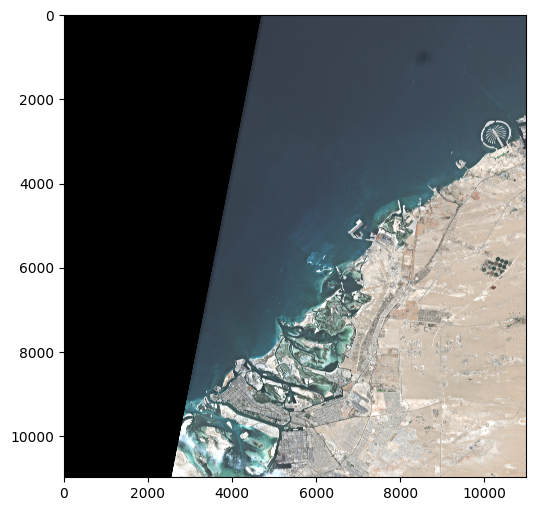

In [8]:
# Plot raster data
plt.figure(figsize=(6, 6))
plt.imshow(rgb(array))

In [9]:
#Rasterize vector data
vector = ogr.Open(vector_path) # load vector data
vector_layer = vector.GetLayer() # get layer

In [10]:
output = '/content/drive/MyDrive/SAMPLE/Copy of output.tif' # output file path
driver = gdal.GetDriverByName('GTiff') # get driver
output_data = driver.Create(output, raster.RasterXSize, raster.RasterYSize, 1, gdal.GDT_Byte) # create GeoTiff with the same size of raster
output_data.SetProjection(raster.GetProjection()) # set projection
output_data.SetGeoTransform(raster.GetGeoTransform()) # set affine transformation
gdal.RasterizeLayer(output_data, [1], vector_layer, burn_values=[1]) # rasterize

0

In [11]:
# Close data
raster=None
vector=None
output_data=None

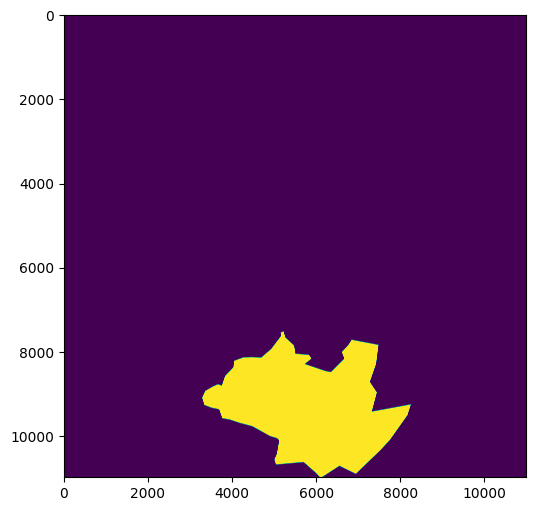

In [12]:
# Plot rasterized vector data
rasterized = gdal.Open(output).ReadAsArray()
plt.figure(figsize=(6, 6))
plt.imshow(rasterized)

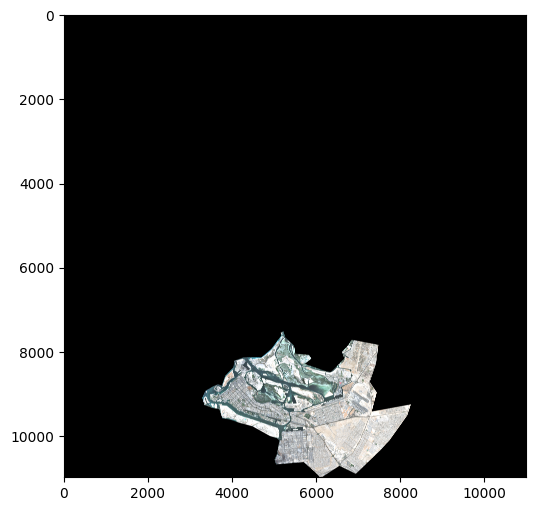

In [13]:
# Plot raster data masked by vector data
array[np.where(rasterized!=1)]=0
plt.figure(figsize=(6, 6))
plt.imshow(rgb(array))